In [ ]:
!pip install wandb
!pip install wordcloud
!pip install colour

In [ ]:
## Installing font for Hindi for matplotlib ##
!apt-get install -y fonts-lohit-deva
!fc-list :lang=hi family

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-lohit-deva
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 78.9 kB of archives.
After this operation, 198 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-lohit-deva all 2.95.4-4 [78.9 kB]
Fetched 78.9 kB in 1s (94.9 kB/s)
Selecting previously unselected package fonts-lohit-deva.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-lohit-deva_2.95.4-4_all.deb ...
Unpacking fonts-lohit-deva (2.95.4-4) ...
Setting up fonts-lohit-deva (2.95.4-4) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Lohit Devanagari


In [ ]:
import os
import random
import time
import wandb
import re, string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from colour import Color
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Download the dataset ##
import requests
import tarfile

def download_data(save_path):

    data_url = r"https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

    r = requests.get(data_url, allow_redirects=True)
    tar_path = "data_assignment3.tar"

    if r.status_code == 200:
        with open(tar_path, 'wb') as f:
            f.write(r.content)

    tar_file = tarfile.open(tar_path)
    tar_file.extractall(save_path)
    tar_file.close()


# downloading and extracting the data to drive
# uncomment the line below if downloading data for the 1st time
#download_data("/content/drive/MyDrive/DakshinaDataset")

In [ ]:
# Files with English to Devanagari (Hindi) translation word by word
# Punctutations have already been cleaned from this file

def get_data_files(language):
    """ Function fo read data
    """

    ## REPLACE THIS PATH UPTO dakshina_dataset_v1.0 with your own dataset path ##
    template = "/content/drive/MyDrive/DakshinaDataset/dakshina_dataset_v1.0/{}/lexicons/{}.translit.sampled.{}.tsv"

    train_tsv = template.format(language, language, "train")
    val_tsv = template.format(language, language, "dev")
    test_tsv = template.format(language, language, "test")

    return train_tsv, val_tsv, test_tsv

## Utility functions for preprocessing data ##

def add_start_end_tokens(df, cols, sos="\t", eos="\n"):
    """ Adds EOS and SOS tokens to data
    """
    def add_tokens(s):
        # \t = starting token
        # \n = ending token
        return sos + str(s) + eos

    for col in cols:
        df[col] = df[col].apply(add_tokens)

def tokenize(lang, tokenizer=None):
    """ Uses tf.keras tokenizer to tokenize the data/words into characters
    """

    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)

        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    else:
        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    return lang_tensor, tokenizer

def preprocess_data(fpath, input_lang_tokenizer=None, targ_lang_tokenizer=None):
    """ Reads, tokenizes and adds SOS/EOS tokens to data based on above functions
    """

    df = pd.read_csv(fpath, sep="\t", header=None)

    # adding start and end tokens to know when to stop predicting
    add_start_end_tokens(df, [0,1])

    input_lang_tensor, input_tokenizer = tokenize(df[1].astype(str).tolist(),
                                                    tokenizer=input_lang_tokenizer)

    targ_lang_tensor, targ_tokenizer = tokenize(df[0].astype(str).tolist(),
                                                    tokenizer=targ_lang_tokenizer)

    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset))

    return dataset, input_tokenizer, targ_tokenizer

In [ ]:
def get_layer(name, units, dropout, return_state=False, return_sequences=False):
    name = name.lower()
    if name == "rnn":
        return layers.SimpleRNN(units=units, dropout=dropout,
                                return_state=return_state,
                                return_sequences=return_sequences)
    if name == "gru":
        return layers.GRU(units=units, dropout=dropout,
                          return_state=return_state,
                          return_sequences=return_sequences)
    if name == "lstm":
        return layers.LSTM(units=units, dropout=dropout,
                           return_state=return_state,
                           return_sequences=return_sequences)
    raise ValueError(f"Unknown layer type: {name}")

#  Bahdanau Attention
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, enc_state, enc_out):

    enc_state = tf.concat(enc_state, 1)
    enc_state = tf.expand_dims(enc_state, 1)

    score = self.V(tf.nn.tanh(self.W1(enc_state) + self.W2(enc_out)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * enc_out
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights
class Encoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, vocab_size, embedding_dim, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.units = units
        self.layer_type = layer_type.lower()
        self.dropout = dropout
        self.embedding = layers.Embedding(vocab_size, embedding_dim)

        # Build stacked RNN layers
        self.rnn_layers = []
        if n_layers == 1:
            # Single layer: return full sequence and final state
            self.rnn_layers.append(get_layer(self.layer_type, units, dropout,
                                             return_sequences=True, return_state=True))
        else:
            # Intermediate layers: return sequences, no state
            for _ in range(n_layers - 1):
                self.rnn_layers.append(get_layer(self.layer_type, units, dropout,
                                                 return_sequences=True, return_state=False))
            # Final layer: return sequences and state
            self.rnn_layers.append(get_layer(self.layer_type, units, dropout,
                                             return_sequences=True, return_state=True))

    def call(self, x, hidden):
        """
        x: input tokens (batch, timesteps)
        hidden: initial hidden state(s).
                For LSTM: [h, c], for GRU/RNN: [h].
        Returns: output sequence and final state list.
        """
        # Embed inputs
        x = self.embedding(x)  # (batch, timesteps, embed_dim)
        output = x

        # Prepare initial state for first layer
        if self.layer_type == "lstm":
            initial_state = hidden  # [h, c]
        else:
            # GRU/RNN: hidden is [h]
            initial_state = hidden[0] if isinstance(hidden, list) else hidden

        # Single-layer case
        if self.n_layers == 1:
            if self.layer_type == "lstm":
                output, state_h, state_c = self.rnn_layers[0](output, initial_state=initial_state)
                return output, [state_h, state_c]
            else:
                output, state_h = self.rnn_layers[0](output, initial_state=initial_state)
                return output, [state_h]

        # Multi-layer case
        # First layer with initial state
        output = self.rnn_layers[0](output, initial_state=initial_state)
        # Intermediate layers (no state returned)
        for layer in self.rnn_layers[1:-1]:
            output = layer(output)
        # Final layer returns sequence + state(s)
        if self.layer_type == "lstm":
            output, state_h, state_c = self.rnn_layers[-1](output)
            return output, [state_h, state_c]
        else:
            output, state_h = self.rnn_layers[-1](output)
            return output, [state_h]

    def initialize_hidden_state(self, batch_size):
        """Returns initial zero state."""
        if self.layer_type == "lstm":
            return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]
        else:
            return [tf.zeros((batch_size, self.units))]


class Decoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, vocab_size, embedding_dim, dropout, attention=False):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.units = units
        self.layer_type = layer_type.lower()
        self.dropout = dropout
        self.attention = attention

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        if self.attention:
            self.attention_layer = BahdanauAttention(units)

        # Build stacked RNN layers for decoder
        self.rnn_layers = []
        if n_layers == 1:
            # Single layer: no time dimension output (one step), return state
            self.rnn_layers.append(get_layer(self.layer_type, units, dropout,
                                             return_sequences=False, return_state=True))
        else:
            # Intermediate layers: return sequences + state
            for _ in range(n_layers - 1):
                self.rnn_layers.append(get_layer(self.layer_type, units, dropout,
                                                 return_sequences=True, return_state=True))
            # Final layer: no time dimension (one step), return state
            self.rnn_layers.append(get_layer(self.layer_type, units, dropout,
                                             return_sequences=False, return_state=True))

        self.dense = layers.Dense(vocab_size, activation='softmax')

    def call(self, x, hidden, enc_out=None):
        """
        x: decoder input tokens (batch, 1)
        hidden: initial hidden state(s) from encoder ([h, c] or [h])
        enc_out: encoder outputs for attention (if any)
        Returns: (predictions, new_state_list, attention_weights)
        """
        x = self.embedding(x)  # (batch, 1, embed_dim)

        # Apply attention if available
        if self.attention and enc_out is not None:
            context_vector, attention_weights = self.attention_layer(hidden, enc_out)
            context_vector = tf.expand_dims(context_vector, 1)  # (batch, 1, units)
            x = tf.concat([context_vector, x], axis=-1)
        else:
            attention_weights = None

        output = x

        # Prepare initial state for first layer
        if self.layer_type == "lstm":
            initial_state = hidden  # [h, c]
        else:
            initial_state = hidden[0] if isinstance(hidden, list) else hidden

        # First layer with initial state
        if self.layer_type == "lstm":
            output, state_h, state_c = self.rnn_layers[0](output, initial_state=initial_state)
        else:
            output, state_h = self.rnn_layers[0](output, initial_state=initial_state)

        # Pass through remaining layers
        for layer in self.rnn_layers[1:]:
            if self.layer_type == "lstm":
                output, state_h, state_c = layer(output)
            else:
                output, state_h = layer(output)

        # Final output (no time dimension)
        output = self.dense(output)  # (batch, vocab_size)

        # Return state list appropriately
        if self.layer_type == "lstm":
            return output, [state_h, state_c], attention_weights
        else:
            return output, [state_h], attention_weights



In [ ]:
class BeamSearch():
    def __init__(self, model, k):
        self.k = k
        self.model = model
        self.acc = tf.keras.metrics.Accuracy()

    def sample_beam_search(self, probs):

        m, n = probs.shape
        output_sequences = [[[], 0.0]]

        for row in probs:
            beams = []

            for tup in output_sequences:
                seq, score = tup
                for j in range(n):
                    new_beam = [seq + [j], score - tf.math.log(row[j])]
                    beams.append(new_beam)

            output_sequences = sorted(beams, key=lambda x: x[1])[:self.k]

        tensors, scores = list(zip(*output_sequences))
        tensors = list(map(lambda x: tf.expand_dims(tf.constant(x),0), tensors))

        return tf.concat(tensors, 0), scores

    def beam_accuracy(self, input, target):
        accs = []

        for i in range(self.k):
            self.acc.reset_state()
            self.acc.update_state(target, input[i, :])
            accs.append(self.acc.result())

        return max(accs)

    def step(self, input, target, enc_state):

        batch_acc = 0
        sequences = []

        enc_out, enc_state = self.model.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*self.model.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        for i in range(target.shape[0]):

            possibilities, scores = self.sample_beam_search(sequences[i, :, :])
            batch_acc += self.beam_accuracy(possibilities, target[i, 1:])

        batch_acc = batch_acc / target.shape[0]

        return 0, batch_acc

    def evaluate(self, test_dataset, batch_size=None, upto=5, use_wandb=False):

        if batch_size is not None:
            self.model.batch_size = batch_size
            test_dataset = test_dataset.batch(batch_size)
        else:
            self.model.batch_size = 1

        test_acc = 0
        enc_state = self.model.encoder.initialize_hidden_state(self.model.batch_size)

        for batch, (input, target) in enumerate(test_dataset.take(upto)):

           _, acc = self.step(input, target, enc_state)
           test_acc += acc

        if use_wandb:
            wandb.log({"test acc (beam search)": test_acc / upto})

        print(f"Test Accuracy on {upto*batch_size} samples: {test_acc / upto:.4f}\n")

    def translate(self, word):

        word = "\t" + word + "\n"
        sequences = []
        result = []

        inputs = self.model.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.model.max_input_len,
                                                               padding="post")


        enc_state = self.model.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.model.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.model.max_target_len):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        possibilities, scores = self.sample_beam_search(tf.squeeze(sequences, 0))
        output_words = self.model.targ_tokenizer.sequences_to_texts(possibilities.numpy())

        def post_process(word):
            word = word.split(" ")[:-1]
            return "".join([x for x in word])

        output_words = list(map(post_process, output_words))

        return output_words, scores

In [ ]:
class Seq2SeqModel():
    def __init__(self, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention=False):
        self.embedding_dim = embedding_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.layer_type = layer_type
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.stats = []
        self.batch_size = 128
        self.use_beam_search = False

    def build(self, loss, optimizer, metric):
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def set_vocabulary(self, input_tokenizer, targ_tokenizer):
        self.input_tokenizer = input_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.create_model()

    def create_model(self):

        encoder_vocab_size = len(self.input_tokenizer.word_index) + 1
        decoder_vocab_size = len(self.targ_tokenizer.word_index) + 1

        self.encoder = Encoder(self.layer_type, self.encoder_layers, self.units, encoder_vocab_size,
                               self.embedding_dim, self.dropout)

        self.decoder = Decoder(self.layer_type, self.decoder_layers, self.units, decoder_vocab_size,
                               self.embedding_dim,  self.dropout, self.attention)

    @tf.function
    def train_step(self, input, target, enc_state):

        loss = 0

        with tf.GradientTape() as tape:

            enc_out, enc_state = self.encoder(input, enc_state)

            dec_state = enc_state
            dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

            ## We use Teacher forcing to train the network
            ## Each target at timestep t is passed as input for timestep t + 1

            if random.random() < self.teacher_forcing_ratio:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)

                    dec_input = tf.expand_dims(target[:,t], 1)

            else:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)

                    preds = tf.argmax(preds, 1)
                    dec_input = tf.expand_dims(preds, 1)


            batch_loss = loss / target.shape[1]

            variables = self.encoder.variables + self.decoder.variables
            gradients = tape.gradient(loss, variables)

            self.optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss, self.metric.result()

    @tf.function
    def validation_step(self, input, target, enc_state):

        loss = 0

        enc_out, enc_state = self.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
            loss += self.loss(target[:,t], preds)
            self.metric.update_state(target[:,t], preds)

            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        batch_loss = loss / target.shape[1]

        return batch_loss, self.metric.result()


    def fit(self, dataset, val_dataset, batch_size=128, epochs=10, use_wandb=False, teacher_forcing_ratio=1.0):

        self.batch_size = batch_size
        self.teacher_forcing_ratio = teacher_forcing_ratio

        steps_per_epoch = len(dataset) // self.batch_size
        steps_per_epoch_val = len(val_dataset) // self.batch_size

        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        val_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)

        # useful when we need to translate the sentence
        sample_inp, sample_targ = next(iter(dataset))
        self.max_target_len = sample_targ.shape[1]
        self.max_input_len = sample_inp.shape[1]

        template = "\nTrain Loss: {0:.4f} Train Accuracy: {1:.4f} Validation Loss: {2:.4f} Validation Accuracy: {3:.4f}"

        print("-"*100)
        for epoch in range(1, epochs+1):
            print(f"EPOCH {epoch}\n")

            ## Training loop ##
            total_loss = 0
            total_acc = 0
            self.metric.reset_state()

            starting_time = time.time()
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("Training ...\n")
            for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
                batch_loss, acc = self.train_step(input, target, enc_state)
                total_loss += batch_loss
                total_acc += acc


                if batch==0 or ((batch + 1) % 100 == 0):
                    print(f"Batch {batch+1} Loss {batch_loss:.4f}")

            avg_acc = total_acc / steps_per_epoch
            avg_loss = total_loss / steps_per_epoch

            # Validation loop ##
            total_val_loss = 0
            total_val_acc = 0
            self.metric.reset_state()

            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("\nValidating ...")
            for batch, (input, target) in enumerate(val_dataset.take(steps_per_epoch_val)):
                batch_loss, acc = self.validation_step(input, target, enc_state)
                total_val_loss += batch_loss
                total_val_acc += acc

            avg_val_acc = total_val_acc / steps_per_epoch_val
            avg_val_loss = total_val_loss / steps_per_epoch_val

            print(template.format(avg_loss, avg_acc*100, avg_val_loss, avg_val_acc*100))

            time_taken = time.time() - starting_time
            self.stats.append({"epoch": epoch,
                            "train loss": avg_loss,
                            "val loss": avg_val_loss,
                            "train acc": avg_acc*100,
                            "val acc": avg_val_acc*100,
                            "training time": time_taken})

            if use_wandb:
                wandb.log(self.stats[-1])

            print(f"\nTime taken for the epoch {time_taken:.4f}")
            print("-"*100)

        print("\nModel trained successfully !!")

    def evaluate(self, test_dataset, batch_size=None):

        if batch_size is not None:
            self.batch_size = batch_size

        steps_per_epoch_test = len(test_dataset) // batch_size
        test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        self.metric.reset_state()

        enc_state = self.encoder.initialize_hidden_state(self.batch_size)

        print("\nRunning test dataset through the model...\n")
        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):
            batch_loss, acc = self.validation_step(input, target, enc_state)
            total_test_loss += batch_loss
            total_test_acc += acc

        avg_test_acc = total_test_acc / steps_per_epoch_test
        avg_test_loss = total_test_loss / steps_per_epoch_test

        print(f"Test Loss: {avg_test_loss:.4f} Test Accuracy: {avg_test_acc:.4f}")

        return avg_test_loss, avg_test_acc


    def translate(self, word, get_heatmap=False):

        word = "\t" + word + "\n"

        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.max_input_len,
                                                               padding="post")

        result = ""
        att_wts = []

        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.max_target_len):

            preds, dec_state, attention_weights = self.decoder(dec_input, dec_state, enc_out)

            if get_heatmap:
                att_wts.append(attention_weights)

            preds = tf.argmax(preds, 1)
            next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], att_wts[:-1]

        return result[:-1], att_wts[:-1]

    def plot_attention_heatmap(self, word, ax, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

        translated_word, attn_wts = self.translate(word, get_heatmap=True)
        attn_heatmap = tf.squeeze(tf.concat(attn_wts, 0), -1).numpy()

        input_word_len = len(word)
        output_word_len = len(translated_word)

        ax.imshow(attn_heatmap[:, :input_word_len])

        font_prop = FontProperties(fname=font_path, size=18)

        ax.set_xticks(np.arange(input_word_len))
        ax.set_yticks(np.arange(output_word_len))

        ax.set_xticklabels(list(word))
        ax.set_yticklabels(list(translated_word), fontproperties=font_prop)


# Visualize Outputs

In [ ]:
def get_colors(inputs, targets, preds):

    n = len(targets)
    smoother = SmoothingFunction().method2
    def get_scores(target, output, smoother):
        return sentence_bleu(list(list(target)), list(output), smoothing_function=smoother)

    red = Color("red")
    colors = list(red.range_to(Color("violet"),n))
    colors = list(map(lambda c: c.hex, colors))

    scores = []
    for i in range(n):
        scores.append(get_scores(targets[i], preds[i], smoother))

    d = dict(zip(sorted(scores), list(range(n))))
    ordered_colors = list(map(lambda x: colors[d[x]], scores))

    input_colors = dict(zip(inputs, ordered_colors))
    target_colors = dict(zip(targets, ordered_colors))
    pred_colors = dict(zip(preds, ordered_colors))

    return input_colors, target_colors, pred_colors


class Colorizer():
    def __init__(self, word_to_color, default_color):

        self.word_to_color = word_to_color
        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

def randomly_evaluate(model, test_file=get_data_files("hi")[2], n=10):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    print(f"Randomly evaluating the model on {n} words\n")

    for i in range(n):
        word = str(df[1][i])

        print(f"Input word: {word}")
        print(f"Actual translation: {str(df[0][i])}")
        print(f"Model translation: {model.translate(word)[0]}\n")

def visualize_model_outputs(model, test_file=get_data_files("hi")[2], n=10, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    inputs = df[1].astype(str).tolist()
    targets = df[0].astype(str).tolist()
    preds = list(map(lambda word: model.translate(word)[0], inputs))

    # Generate colors for the words
    input_colors, target_colors, pred_colors =  get_colors(inputs, targets, preds)
    color_fn_ip = Colorizer(input_colors, "white")
    color_fn_tr = Colorizer(target_colors, "white")
    color_fn_op = Colorizer(pred_colors, "white")

    input_text = Counter(inputs)
    target_text = Counter(targets)
    output_text = Counter(preds)

    fig, axs = plt.subplots(1,3, figsize=(30, 15))
    plt.tight_layout()

    wc_in = WordCloud(random_state=1).generate_from_frequencies(input_text)
    wc_out = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(output_text)
    wc_tar = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(target_text)

    axs[0].set_title("Input words", fontsize=30)
    axs[0].imshow(wc_in.recolor(color_func=color_fn_ip))
    axs[1].set_title("Target words", fontsize=30)
    axs[1].imshow(wc_tar.recolor(color_func=color_fn_tr))
    axs[2].set_title("Model outputs", fontsize=30)
    axs[2].imshow(wc_out.recolor(color_func=color_fn_op))
    plt.show()



def test_on_dataset(language, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention, teacher_forcing_ratio=1.0, save_outputs=None):

    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    model = Seq2SeqModel(embedding_dim,
                         encoder_layers,
                         decoder_layers,
                         layer_type,
                         units,
                         dropout,
                         attention)

    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())

    model.fit(dataset, val_dataset, epochs=30, use_wandb=False, teacher_forcing_ratio=teacher_forcing_ratio)

    ## Character level accuracy ##
    test_dataset, _, _ = preprocess_data(TEST_TSV, model.input_tokenizer, model.targ_tokenizer)
    test_loss, test_acc = model.evaluate(test_dataset, batch_size=100)

    ##  Word level accuracy ##
    test_tsv = pd.read_csv(TEST_TSV, sep="\t", header=None)
    inputs = test_tsv[1].astype(str).tolist()
    targets = test_tsv[0].astype(str).tolist()

    outputs = []

    for word in inputs:
        outputs.append(model.translate(word)[0])

    def word_level_acc(outputs, targets):
        return np.sum(np.asarray(outputs) == np.array(targets)) / len(outputs)

    print(f"Word level accuracy: {word_level_acc(outputs, targets)}")

    if save_outputs is not None:
        df = pd.DataFrame()
        df["inputs"] = inputs
        df["targets"] = targets
        df["outputs"] = outputs
        df.to_csv(save_outputs)


    return model


# For Question 6: Inspecting Neural Connectivity in the Model

In [ ]:
# Tools for getting model connectivity between input and output characters
def get_lstm_output(decoder, x, hidden, enc_out=None):

    x = decoder.embedding_layer(x)

    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None

    x = decoder.rnn_layers[0](x, initial_state=hidden)

    for layer in decoder.rnn_layers[1:]:
        x = layer(x)

    output, state = x[0], x[1:]

    #output = decoder.dense(decoder.flatten(output))

    return output, state, attention_weights

def get_output_from_embedding(encoder, x, hidden):

    x = encoder.rnn_layers[0](x, initial_state=hidden)

    for layer in encoder.rnn_layers[1:]:
        x = layer(x)

    output, state = x[0], x[1:]

    return output, state


def get_connectivity(model, word):

    word = "\t" + word + "\n"

    inputs = model.input_tokenizer.texts_to_sequences([word])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                            maxlen=model.max_input_len,
                                                            padding="post")

    result = ""

    gradient_list = []

    enc_state = model.encoder.initialize_hidden_state(1)
    embedded_in = model.encoder.embedding(inputs)


    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        tape.watch(embedded_in)

        enc_out, enc_state = get_output_from_embedding(model.encoder, embedded_in, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, model.max_target_len):

            lstm_out, dec_state, _ = get_lstm_output(model.decoder, dec_input, dec_state, enc_out)

            preds = model.decoder.dense(model.decoder.flatten(lstm_out))
            gradient_list.append(tape.gradient(lstm_out, embedded_in)[0])

            preds = tf.argmax(preds, 1)
            next_char = model.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], gradient_list[:-1]

        return result[:-1], gradient_list[:-1]

In [ ]:
# Imports for visualising the model connectivity
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from IPython.display import HTML as html_print
from IPython.display import display
import tensorflow.keras.backend as K

# get html element
def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

# print html
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
      '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
      '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
      '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = int(value * 19)
    if value == 19:
        value -= 1
    return colors[value]

# sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z

def softmax(x):
    v = np.exp(x)
    v = v / np.sum(v)
    return v

def get_gradient_norms(grad_list, word, activation="sigmoid"):
    grad_norms = []
    for grad_tensor in grad_list:
        grad_mags = tf.norm(grad_tensor, axis=1)
        grad_mags = grad_mags[:len(word)]
        if activation == "softmax":
            grad_mags_scaled = softmax(grad_mags)
        elif activation == "scaler":
            scaler = MinMaxScaler()
            grad_mags = tf.reshape(grad_mags, (-1,1))
            grad_mags_scaled = scaler.fit_transform(grad_mags)
        else:
            grad_mags_scaled = sigmoid(grad_mags)
        grad_norms.append(grad_mags_scaled)
    return grad_norms

def visualize(grad_norms, word, translated_word):
    print("Original Word:", word)
    print("Transliterated Word:", translated_word)
    for i in range(len(translated_word)):
        print("Connectivity Visualization for", translated_word[i],":")
        text_colours = []
        for j in range(len(grad_norms[i])):
            text = (word[j], get_clr(grad_norms[i][j]))
            text_colours.append(text)
        print_color(text_colours)

def visualise_connectivity(model, word, activation="sigmoid"):
    translated_word, grad_list = get_connectivity(model, word)
    grad_norms = get_gradient_norms(grad_list, word, activation)
    visualize(grad_norms, word, translated_word)

In [ ]:
model = test_on_dataset(language="hi",
                        embedding_dim=256,
                        encoder_layers=1,
                        decoder_layers=1,
                        layer_type="lstm",
                        units=256,
                        dropout=0.3,
                        attention=False)

----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9886
Batch 100 Loss 1.1730
Batch 200 Loss 0.9675
Batch 300 Loss 0.8902

Validating ...

Train Loss: 1.0974 Train Accuracy: 67.1118 Validation Loss: 2.7479 Validation Accuracy: 45.2474

Time taken for the epoch 100.8130
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8948
Batch 100 Loss 0.8160
Batch 200 Loss 0.8000
Batch 300 Loss 0.7038

Validating ...

Train Loss: 0.8094 Train Accuracy: 75.1404 Validation Loss: 2.9857 Validation Accuracy: 48.1885

Time taken for the epoch 27.0900
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7246
Batch 100 Loss 0.6105
Batch 200 Loss 0.5454
Batch 300 Loss 0.4892

Validating ...

Train Loss: 0.5672 Train Accuracy: 80.7534 Validation Loss

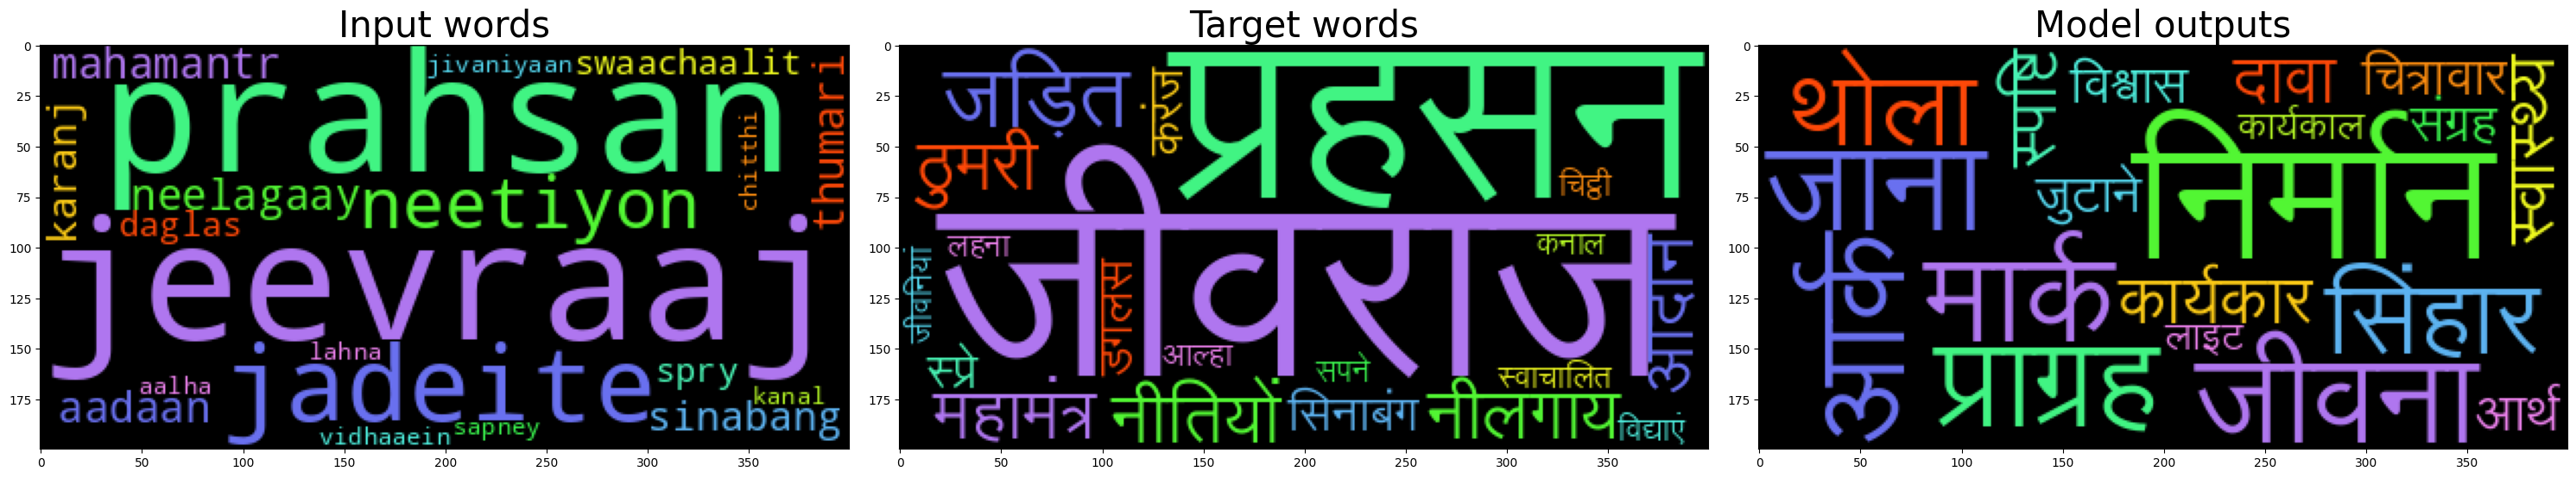

In [ ]:
visualize_model_outputs(model, n=20)

In [ ]:
def get_test_words(n):
    test_df = pd.read_csv(get_data_files("hi")[2])
    test_sample = test_df.sample(n)
    test_sample.reset_index(inplace=True, drop=True)
    test_words = []
    for i in test_sample.index:
        entry = test_sample["अंक\tank\t5"].loc[i]
        parts = entry.split("\t")
        word = parts[1]
        test_words.append(word)
    return test_words

test_words = get_test_words(5)
print(test_words)

['patki', 'jamaeya', 'tarabai', 'sasakon', 'janajagran']


In [ ]:
for word in test_words:
    visualise_connectivity(model, word, activation="scaler")

Original Word: laurens
Transliterated Word: लारेंस
Connectivity Visualization for ल :


Connectivity Visualization for ा :


Connectivity Visualization for र :


Connectivity Visualization for े :


Connectivity Visualization for ं :


Connectivity Visualization for स :


Original Word: jivaniyaan
Transliterated Word: जीवाणियां
Connectivity Visualization for ज :


Connectivity Visualization for ी :


Connectivity Visualization for व :


Connectivity Visualization for ा :


Connectivity Visualization for ण :


Connectivity Visualization for ि :


Connectivity Visualization for य :


Connectivity Visualization for ा :


Connectivity Visualization for ं :


Original Word: karykartaon
Transliterated Word: कार्यकर्ताओं
Connectivity Visualization for क :


Connectivity Visualization for ा :


Connectivity Visualization for र :


Connectivity Visualization for ् :


Connectivity Visualization for य :


Connectivity Visualization for क :


Connectivity Visualization for र :


Connectivity Visualization for ् :


Connectivity Visualization for त :


Connectivity Visualization for ा :


Connectivity Visualization for ओ :


Connectivity Visualization for ं :


Original Word: vaishakh
Transliterated Word: वैशाख
Connectivity Visualization for व :


Connectivity Visualization for ै :


Connectivity Visualization for श :


Connectivity Visualization for ा :


Connectivity Visualization for ख :


Original Word: caolan
Transliterated Word: कैलन
Connectivity Visualization for क :


Connectivity Visualization for ै :


Connectivity Visualization for ल :


Connectivity Visualization for न :


In [ ]:
randomly_evaluate(model, n=5)

Randomly evaluating the model on 5 words

Input word: tau
Actual translation: टाऊ
Model translation: तार्थ

Input word: complex
Actual translation: कॉम्प्लेक्स
Model translation: कॉल

Input word: charts
Actual translation: चार्ट्स
Model translation: चार्ट

Input word: slash
Actual translation: स्लैश
Model translation: स्मार्टिया

Input word: prayaasrat
Actual translation: प्रयासरत
Model translation: प्रतिराष्ट्री



In [ ]:
randomly_evaluate(model, n=5)

Randomly evaluating the model on 5 words

Input word: lochdar
Actual translation: लोचदार
Model translation: लोचदार

Input word: qawwaliyon
Actual translation: कव्वालियों
Model translation: क्ववेलियों

Input word: unatees
Actual translation: उनतीस
Model translation: युमालिद

Input word: bhabar
Actual translation: भाबर
Model translation: भाबर

Input word: raalod
Actual translation: रालोद
Model translation: रालोद



# Wandb Function

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sonalikasingh299 (sonalikasingh299-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# train function
def train_with_wandb(language, test_beam_search=False):

    config_defaults = {"embedding_dim": 64,
                       "enc_dec_layers": 1,
                       "layer_type": "lstm",
                       "units": 128,
                       "dropout": 0,
                       "attention": False,
                       "beam_width": 3,
                       "teacher_forcing_ratio": 1.0
                       }

    wandb.init(config=config_defaults, project="DA6401-Assignment_03", resume=True)

    #wandb.run.name
    wandb.run.name=f"edim_{wandb.config.embedding_dim}_edl_{wandb.config.enc_dec_layers}_lr_{wandb.config.layer_type}_units_{wandb.config.units}_dp_{wandb.config.dropout}_att_{wandb.config.attention}_bw_{wandb.config.beam_width}_tfc_{wandb.config.teacher_forcing_ratio}"
    # Change run name for the sweep with attention Mechanism
	  #wandb.run.name=f"layers_{wandb.config.enc_dec_layers}_units_{wandb.config.units}_dp_{wandb.config.dropout}_att_{wandb.config.attention}"

    ## 1. SELECT LANGUAGE ##
    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    ## 2. DATA PREPROCESSING ##
    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    ## 3. CREATING THE MODEL ##
    model = Seq2SeqModel(embedding_dim=wandb.config.embedding_dim,
                         encoder_layers=wandb.config.enc_dec_layers,
                         decoder_layers=wandb.config.enc_dec_layers,
                         layer_type=wandb.config.layer_type,
                         units=wandb.config.units,
                         dropout=wandb.config.dropout,
                         attention=wandb.config.attention)

    ## 4. COMPILING THE MODEL
    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())

    ## 5. FITTING AND VALIDATING THE MODEL
    model.fit(dataset, val_dataset, epochs=10, use_wandb=True, teacher_forcing_ratio=wandb.config.teacher_forcing_ratio)

    if test_beam_search:
        ## OPTIONAL :- Evaluate the dataset using beam search and without beam search
        val_dataset, _, _ = preprocess_data(VAL_TSV, model.input_tokenizer, model.targ_tokenizer)
        subset = val_dataset.take(500)

        # a) Without beam search
        _, test_acc_without = model.evaluate(subset, batch_size=100)
        wandb.log({"test acc": test_acc_without})

        # b) With beam search
        beam_search = BeamSearch(model=model, k=wandb.config.beam_width)
        beam_search.evaluate(subset, batch_size=100, use_wandb=True)


# Sweep Without use of Attention Mechanism

In [ ]:
sweep_config = {
  "name": "Sweep 1- Assignment3",
   "method": "bayes",
  "metric": {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },

  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [64, 128, 256]
        },
        "layer_type": {
            "values": ["rnn", "gru", "lstm"]
        },
        "embedding_dim": {
            "values": [64, 128, 256]
        },
        "dropout": {
            "values": [0.2, 0.3]
         },
        "beam_width": {
            "values": [3, 5, 7]
        },
            "teacher_forcing_ratio": {
            "values": [0.3, 0.5, 0.7, 0.9]
        }
    }
}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DA6401-Assignment_03")

Create sweep with ID: 7l8wekyg
Sweep URL: https://wandb.ai/sonalikasingh299-iit-madras/DA6401-Assignment_03/sweeps/7l8wekyg


In [ ]:
wandb.agent(sweep_id,function=lambda: train_with_wandb("hi"),project="DA6401-Assignment_03" , count = 5)

wandb: Agent Starting Run: 51b71rzt with config:
wandb: 	beam_width: 3
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: rnn
wandb: 	teacher_forcing_ratio: 0.7
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 4.2427
Batch 100 Loss 1.0685
Batch 200 Loss 0.9792
Batch 300 Loss 0.8995

Validating ...

Train Loss: 1.0820 Train Accuracy: 66.3592 Validation Loss: 2.3937 Validation Accuracy: 56.0484

Time taken for the epoch 89.2404
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9815
Batch 100 Loss 0.9288
Batch 200 Loss 0.9369
Batch 300 Loss 0.9333

Validating ...

Train Loss: 0.9131 Train Accuracy: 73.4492 Validation Loss: 2.9857 Validation Accuracy: 47.7313

Time taken for the epoch 46.0297
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8589
Batch 100 Loss 0.8880
Batch 200 Loss 0.8728
Batch 300 Loss 0.8504

Validating ...

Train Loss: 0.8742 Train Accuracy: 74.3045 Validation Loss: 4.2478 Validation Accuracy: 35.8730

Time taken for the epoch 47.2094
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▆▆▇▇▇███
train loss,█▅▄▃▃▂▂▂▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,█▆▄▆▇▁▆▆▂█
val loss,▁▂▅▃▂█▃▃█▂
epoch,10
train acc,77.71409
train loss,0.7421
training time,46.11506
val acc,54.95747


wandb: Agent Starting Run: z0wpzy5m with config:
wandb: 	beam_width: 7
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: lstm
wandb: 	teacher_forcing_ratio: 0.7
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9904
Batch 100 Loss 1.1975
Batch 200 Loss 1.0925
Batch 300 Loss 1.0503

Validating ...

Train Loss: 1.2531 Train Accuracy: 66.1127 Validation Loss: 2.1579 Validation Accuracy: 57.0321

Time taken for the epoch 54.0370
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9593
Batch 100 Loss 0.9685
Batch 200 Loss 0.9104
Batch 300 Loss 0.8863

Validating ...

Train Loss: 0.9329 Train Accuracy: 72.6784 Validation Loss: 1.9080 Validation Accuracy: 56.3631

Time taken for the epoch 24.3770
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9122
Batch 100 Loss 0.8899
Batch 200 Loss 0.8669
Batch 300 Loss 0.8262

Validating ...

Train Loss: 0.8457 Train Accuracy: 75.1159 Validation Loss: 2.2006 Validation Accuracy: 53.1822

Time taken for the epoch 22.8487
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▄▅▅▆▇▇▇██
train loss,█▅▄▃▃▂▂▂▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▄▄▁▃▃▃▅▇██
val loss,▅▁▆▅▆█▅▄▄▄
epoch,10
train acc,82.89526
train loss,0.54958
training time,24.54257
val acc,61.35023


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65ipe0tf with config:
wandb: 	beam_width: 7
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 256
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: rnn
wandb: 	teacher_forcing_ratio: 0.5
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 4.2089
Batch 100 Loss 1.2947
Batch 200 Loss 1.2648
Batch 300 Loss 1.2514

Validating ...

Train Loss: 1.3465 Train Accuracy: 61.3211 Validation Loss: 1.5887 Validation Accuracy: 56.7314

Time taken for the epoch 63.6503
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.2276
Batch 100 Loss 1.2924
Batch 200 Loss 1.3300
Batch 300 Loss 1.2142

Validating ...

Train Loss: 1.2788 Train Accuracy: 66.3412 Validation Loss: 1.5860 Validation Accuracy: 57.1171

Time taken for the epoch 33.6993
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.2405
Batch 100 Loss 1.2769
Batch 200 Loss 1.2251
Batch 300 Loss 1.2674

Validating ...

Train Loss: 1.2785 Train Accuracy: 66.3518 Validation Loss: 1.6068 Validation Accuracy: 56.7420

Time taken for the epoch 32.6342
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▅▅▆▇▇▆▇█
train loss,▇▅▅█▄▂▃▄▂▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▇█▇▁▁▂▂█▇▇
val loss,▁▁▁▇▇█▄▂▂▂
epoch,10
train acc,69.18375
train loss,1.16649
training time,34.24665
val acc,56.6106


wandb: Agent Starting Run: yq329i75 with config:
wandb: 	beam_width: 3
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: lstm
wandb: 	teacher_forcing_ratio: 0.3
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9880
Batch 100 Loss 1.2616
Batch 200 Loss 1.2119
Batch 300 Loss 1.1351

Validating ...

Train Loss: 1.2262 Train Accuracy: 65.1475 Validation Loss: 1.3921 Validation Accuracy: 60.1226

Time taken for the epoch 39.2782
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1100
Batch 100 Loss 1.0857
Batch 200 Loss 1.0793
Batch 300 Loss 1.0778

Validating ...

Train Loss: 1.0586 Train Accuracy: 69.4633 Validation Loss: 1.2817 Validation Accuracy: 61.7048

Time taken for the epoch 16.9580
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0252
Batch 100 Loss 0.9554
Batch 200 Loss 0.8789
Batch 300 Loss 0.8693

Validating ...

Train Loss: 0.9157 Train Accuracy: 72.1283 Validation Loss: 1.0447 Validation Accuracy: 67.8932

Time taken for the epoch 18.2996
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▂▃▄▅▆▇▇██
train loss,█▇▆▄▃▂▂▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▂▃▅▆▇▇▇██
val loss,█▇▅▄▂▂▂▁▁▁
epoch,10
train acc,88.18753
train loss,0.33607
training time,17.55247
val acc,82.19504


wandb: Agent Starting Run: c57hn75n with config:
wandb: 	beam_width: 7
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 256
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: lstm
wandb: 	teacher_forcing_ratio: 0.9
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9907
Batch 100 Loss 1.3597
Batch 200 Loss 1.1631
Batch 300 Loss 1.1588

Validating ...

Train Loss: 1.3059 Train Accuracy: 64.4855 Validation Loss: 1.5237 Validation Accuracy: 56.3968

Time taken for the epoch 52.6748
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1102
Batch 100 Loss 1.1087
Batch 200 Loss 1.1159
Batch 300 Loss 1.0918

Validating ...

Train Loss: 1.1140 Train Accuracy: 68.7087 Validation Loss: 1.4426 Validation Accuracy: 58.2164

Time taken for the epoch 22.2342
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0870
Batch 100 Loss 1.1210
Batch 200 Loss 1.1306
Batch 300 Loss 1.1428

Validating ...

Train Loss: 1.0821 Train Accuracy: 69.5918 Validation Loss: 1.4131 Validation Accuracy: 59.1687

Time taken for the epoch 23.7707
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▄▅▅▆▇▇█
train loss,█▆▅▅▄▃▃▂▂▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▂▃▄▃▅▆▇██
val loss,█▇▇▅▅▄▃▂▁▁
epoch,10
train acc,77.10139
train loss,0.72144
training time,23.70559
val acc,68.5737


# Run more Epoch with same sweep Id = "7l8wekyg"

In [ ]:
wandb.agent(sweep_id= "7l8wekyg",function=lambda: train_with_wandb("hi"),project="DA6401-Assignment_03" , count = 5)

wandb: Agent Starting Run: lj5uurbr with config:
wandb: 	beam_width: 7
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 256
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: rnn
wandb: 	teacher_forcing_ratio: 0.5
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 4.0954
Batch 100 Loss 1.2025
Batch 200 Loss 1.1095
Batch 300 Loss 1.0038

Validating ...

Train Loss: 1.1610 Train Accuracy: 65.3009 Validation Loss: 1.5942 Validation Accuracy: 56.6449

Time taken for the epoch 73.7955
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0120
Batch 100 Loss 0.9715
Batch 200 Loss 0.9630
Batch 300 Loss 0.8819

Validating ...

Train Loss: 0.9403 Train Accuracy: 73.1701 Validation Loss: 1.9023 Validation Accuracy: 50.4739

Time taken for the epoch 33.4240
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8496
Batch 100 Loss 0.8610
Batch 200 Loss 0.8379
Batch 300 Loss 0.8079

Validating ...

Train Loss: 0.8470 Train Accuracy: 75.6415 Validation Loss: 1.8979 Validation Accuracy: 53.6886

Time taken for the epoch 35.3418
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▆▆▇▇▇███
train loss,█▅▄▃▂▂▂▁▁▁
training time,█▁▁▁▁▁▁▁▁▃
val acc,█▃▆▄▇▁▄▁▄▅
val loss,▁▄▄▆▅▇▆█▇▆
epoch,10
train acc,80.59062
train loss,0.63004
training time,44.17753
val acc,53.62556


wandb: Agent Starting Run: ftfscepb with config:
wandb: 	beam_width: 3
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 64
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: lstm
wandb: 	teacher_forcing_ratio: 0.7
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9859
Batch 100 Loss 1.1326
Batch 200 Loss 1.0468
Batch 300 Loss 1.0163

Validating ...

Train Loss: 1.2038 Train Accuracy: 66.6560 Validation Loss: 1.7948 Validation Accuracy: 55.6111

Time taken for the epoch 50.3163
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9581
Batch 100 Loss 0.9619
Batch 200 Loss 0.9108
Batch 300 Loss 0.9012

Validating ...

Train Loss: 0.9227 Train Accuracy: 73.5851 Validation Loss: 1.9861 Validation Accuracy: 54.0992

Time taken for the epoch 17.3351
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8511
Batch 100 Loss 0.8826
Batch 200 Loss 0.8409
Batch 300 Loss 0.8252

Validating ...

Train Loss: 0.8435 Train Accuracy: 75.1650 Validation Loss: 2.2358 Validation Accuracy: 52.5210

Time taken for the epoch 17.7871
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▅▅▆▇▇██
train loss,█▆▅▄▃▃▂▂▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▂▂▁▂▄▅▆▇██
val loss,▃▅█▇▄▄▃▂▁▁
epoch,10
train acc,87.71935
train loss,0.37187
training time,17.26688
val acc,69.80993


wandb: Agent Starting Run: 5nl97qny with config:
wandb: 	beam_width: 5
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 64
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	teacher_forcing_ratio: 0.9
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 4.0245
Batch 100 Loss 1.0972
Batch 200 Loss 0.9337
Batch 300 Loss 0.9097

Validating ...

Train Loss: 1.0832 Train Accuracy: 68.3759 Validation Loss: 2.9553 Validation Accuracy: 40.5568

Time taken for the epoch 39.6028
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.7781
Batch 100 Loss 0.7782
Batch 200 Loss 0.7981
Batch 300 Loss 0.7255

Validating ...

Train Loss: 0.7766 Train Accuracy: 77.9324 Validation Loss: 2.5594 Validation Accuracy: 49.7328

Time taken for the epoch 19.2270
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7529
Batch 100 Loss 0.6630
Batch 200 Loss 0.6853
Batch 300 Loss 0.6756

Validating ...

Train Loss: 0.6887 Train Accuracy: 80.0738 Validation Loss: 2.8242 Validation Accuracy: 46.8034

Time taken for the epoch 20.7073
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▆▆▇▇▇███
train loss,█▅▄▃▂▂▂▁▁▁
training time,█▁▂▁▁▂▁▁▁▁
val acc,▁▇▅▆▆▇▆███
val loss,▇▁▅▅▇▇█▇█▇
epoch,10
train acc,85.53482
train loss,0.46468
training time,18.97077
val acc,50.91405


wandb: Agent Starting Run: q2808n6r with config:
wandb: 	beam_width: 7
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 3
wandb: 	layer_type: lstm
wandb: 	teacher_forcing_ratio: 0.7
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state', 'seed_generator_4/seed_generator_state', 'seed_generator_5/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9912
Batch 100 Loss 1.0655
Batch 200 Loss 1.0640
Batch 300 Loss 0.9053

Validating ...

Train Loss: 1.1411 Train Accuracy: 67.3864 Validation Loss: 1.8760 Validation Accuracy: 57.3244

Time taken for the epoch 59.1018
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9725
Batch 100 Loss 0.9381
Batch 200 Loss 0.8355
Batch 300 Loss 0.8276

Validating ...

Train Loss: 0.8722 Train Accuracy: 74.1943 Validation Loss: 2.0710 Validation Accuracy: 57.0432

Time taken for the epoch 25.1392
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7857
Batch 100 Loss 0.8028
Batch 200 Loss 0.7127
Batch 300 Loss 0.6373

Validating ...

Train Loss: 0.7255 Train Accuracy: 77.4758 Validation Loss: 2.0906 Validation Accuracy: 59.5990

Time taken for the epoch 24.2605
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▅▆▆▇▇██
train loss,█▆▅▄▃▂▂▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▁▂▃▄▅▆▇▇█
val loss,▅██▆▆▄▃▂▂▁
epoch,10
train acc,91.89883
train loss,0.24228
training time,25.12892
val acc,76.09332


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cnn368l1 with config:
wandb: 	beam_width: 3
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: rnn
wandb: 	teacher_forcing_ratio: 0.3
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 4.0780
Batch 100 Loss 1.1324
Batch 200 Loss 0.9392
Batch 300 Loss 0.9903

Validating ...

Train Loss: 1.1203 Train Accuracy: 65.9714 Validation Loss: 2.3493 Validation Accuracy: 53.3500

Time taken for the epoch 72.3805
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.8954
Batch 100 Loss 0.9234
Batch 200 Loss 0.8961
Batch 300 Loss 0.9222

Validating ...

Train Loss: 0.9239 Train Accuracy: 73.2551 Validation Loss: 3.9442 Validation Accuracy: 35.8205

Time taken for the epoch 36.0839
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9180
Batch 100 Loss 0.9202
Batch 200 Loss 0.9212
Batch 300 Loss 0.8787

Validating ...

Train Loss: 0.8940 Train Accuracy: 73.8771 Validation Loss: 2.7269 Validation Accuracy: 55.6163

Time taken for the epoch 36.9892
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▆▆▆▇▇▇███
train loss,█▄▃▃▃▂▂▂▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▇▄██▇▅▄▇▁▄
val loss,▁▄▂▃▃▄▅▂█▇
epoch,10
train acc,77.05404
train loss,0.77177
training time,36.33113
val acc,35.37858


# Sweep With Attention Mechanism

In [ ]:
sweep_config2 = {
  "name": "Attention Sweep - Assignment3",
  "description": "Hyperparameter sweep for Seq2Seq Model with Attention",
  "method": "bayes",
  "metric": {
        "name": "val acc",
        "goal": "maximize"
    },

  "early_terminate": {
        "type": "hyperband",
        "min_iter": 3
    },

  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [128, 256]
        },
        "dropout": {
            "values": [0, 0.2]
        },
        "attention": {
            "values": [True]
        }
    }
}

In [ ]:
sweep_id2 = wandb.sweep(sweep_config2, project="DA6401-Assignment_03")

Create sweep with ID: meus7vyh
Sweep URL: https://wandb.ai/sonalikasingh299-iit-madras/DA6401-Assignment_03/sweeps/meus7vyh


In [ ]:
wandb.agent(sweep_id,function=lambda: train_with_wandb("hi"),project="DA6401-Assignment_03" , count = 5)

wandb: Agent Starting Run: 3kxp6qt8 with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 2
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9917
Batch 100 Loss 1.1877
Batch 200 Loss 1.0561
Batch 300 Loss 1.1247

Validating ...

Train Loss: 1.1920 Train Accuracy: 65.6585 Validation Loss: 1.4182 Validation Accuracy: 59.8122

Time taken for the epoch 59.0695
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1145
Batch 100 Loss 1.1197
Batch 200 Loss 0.9601
Batch 300 Loss 0.8948

Validating ...

Train Loss: 0.9795 Train Accuracy: 70.2591 Validation Loss: 1.0551 Validation Accuracy: 67.2805

Time taken for the epoch 26.8824
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.8331
Batch 100 Loss 0.7078
Batch 200 Loss 0.5546
Batch 300 Loss 0.4945

Validating ...

Train Loss: 0.6286 Train Accuracy: 77.7072 Validation Loss: 0.6537 Validation Accuracy: 78.0835

Time taken for the epoch 27.3811
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▂▄▆▇▇▇███
train loss,█▆▄▂▂▂▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▃▆▇▇█████
val loss,█▅▃▂▁▁▁▁▁▁
epoch,10
train acc,92.17068
train loss,0.23072
training time,28.02154
val acc,85.17054


wandb: Agent Starting Run: 1e60840v with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 4.0031
Batch 100 Loss 0.9957
Batch 200 Loss 0.8689
Batch 300 Loss 0.7829

Validating ...

Train Loss: 0.9630 Train Accuracy: 69.8198 Validation Loss: 2.0820 Validation Accuracy: 55.0910

Time taken for the epoch 41.4211
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.6706
Batch 100 Loss 0.4736
Batch 200 Loss 0.2904
Batch 300 Loss 0.2236

Validating ...

Train Loss: 0.3716 Train Accuracy: 84.5604 Validation Loss: 1.1877 Validation Accuracy: 78.8805

Time taken for the epoch 22.5041
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.1876
Batch 100 Loss 0.2132
Batch 200 Loss 0.1688
Batch 300 Loss 0.1505

Validating ...

Train Loss: 0.1829 Train Accuracy: 93.6623 Validation Loss: 1.1215 Validation Accuracy: 81.9238

Time taken for the epoch 22.3168
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇██████
train loss,█▃▂▂▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▇▇▇██████
val loss,█▂▁▂▁▁▁▂▁▂
epoch,10
train acc,97.47645
train loss,0.07667
training time,22.24904
val acc,84.50806


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4sdi1cgx with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9846
Batch 100 Loss 1.0445
Batch 200 Loss 0.8796
Batch 300 Loss 0.7347

Validating ...

Train Loss: 0.9464 Train Accuracy: 69.8105 Validation Loss: 2.0738 Validation Accuracy: 55.9047

Time taken for the epoch 43.0617
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.6655
Batch 100 Loss 0.3857
Batch 200 Loss 0.2370
Batch 300 Loss 0.2215

Validating ...

Train Loss: 0.3375 Train Accuracy: 85.9345 Validation Loss: 1.1621 Validation Accuracy: 79.2498

Time taken for the epoch 22.6366
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.2109
Batch 100 Loss 0.1927
Batch 200 Loss 0.1736
Batch 300 Loss 0.1747

Validating ...

Train Loss: 0.1794 Train Accuracy: 93.7439 Validation Loss: 1.1214 Validation Accuracy: 81.3795

Time taken for the epoch 22.4293
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇██████
train loss,█▃▂▂▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▇▇███████
val loss,█▂▁▁▁▁▁▁▂▁
epoch,10
train acc,97.51038
train loss,0.07621
training time,22.37175
val acc,85.1516


# Run more epochs with sweep_Id = "meus7vyh"

In [ ]:
wandb.agent(sweep_id = "meus7vyh",function=lambda: train_with_wandb("hi"),project="DA6401-Assignment_03" , count = 10)

wandb: Agent Starting Run: 98rph014 with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 4.0011
Batch 100 Loss 1.1076
Batch 200 Loss 1.0603
Batch 300 Loss 1.0277

Validating ...

Train Loss: 1.1737 Train Accuracy: 66.0341 Validation Loss: 1.3212 Validation Accuracy: 61.4901

Time taken for the epoch 40.5365
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0509
Batch 100 Loss 0.8880
Batch 200 Loss 0.8261
Batch 300 Loss 0.6262

Validating ...

Train Loss: 0.8182 Train Accuracy: 72.1653 Validation Loss: 0.7121 Validation Accuracy: 75.8539

Time taken for the epoch 22.3548
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.5882
Batch 100 Loss 0.5102
Batch 200 Loss 0.4761
Batch 300 Loss 0.4172

Validating ...

Train Loss: 0.4890 Train Accuracy: 82.1130 Validation Loss: 0.5795 Validation Accuracy: 79.3857

Time taken for the epoch 21.9822
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▅▆▇▇▇███
train loss,█▅▃▂▂▂▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▅▆▇▇█████
val loss,█▃▂▂▂▁▁▁▁▁
epoch,10
train acc,91.97111
train loss,0.23365
training time,22.00142
val acc,85.05766


wandb: Agent Starting Run: 54qt4tgl with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9889
Batch 100 Loss 0.9837
Batch 200 Loss 0.8592
Batch 300 Loss 0.7778

Validating ...

Train Loss: 0.9481 Train Accuracy: 69.8549 Validation Loss: 1.9546 Validation Accuracy: 57.0621

Time taken for the epoch 41.0395
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.6662
Batch 100 Loss 0.4236
Batch 200 Loss 0.2608
Batch 300 Loss 0.2534

Validating ...

Train Loss: 0.3550 Train Accuracy: 85.2002 Validation Loss: 1.1637 Validation Accuracy: 79.7751

Time taken for the epoch 22.2995
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.1810
Batch 100 Loss 0.1894
Batch 200 Loss 0.1836
Batch 300 Loss 0.2014

Validating ...

Train Loss: 0.1836 Train Accuracy: 93.6674 Validation Loss: 1.1019 Validation Accuracy: 82.5791

Time taken for the epoch 22.1487
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇██████
train loss,█▃▂▂▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▇▇▇██████
val loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train acc,97.56385
train loss,0.07428
training time,22.12243
val acc,84.75141


wandb: Agent Starting Run: mwfqfbd4 with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9938
Batch 100 Loss 0.9922
Batch 200 Loss 0.9138
Batch 300 Loss 0.7609

Validating ...

Train Loss: 0.9561 Train Accuracy: 69.8983 Validation Loss: 2.0225 Validation Accuracy: 56.1598

Time taken for the epoch 40.0776
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.6767
Batch 100 Loss 0.4836
Batch 200 Loss 0.2680
Batch 300 Loss 0.2043

Validating ...

Train Loss: 0.3901 Train Accuracy: 83.9344 Validation Loss: 1.1500 Validation Accuracy: 79.6999

Time taken for the epoch 22.2446
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.2443
Batch 100 Loss 0.2007
Batch 200 Loss 0.1656
Batch 300 Loss 0.2017

Validating ...

Train Loss: 0.1882 Train Accuracy: 93.4864 Validation Loss: 1.1112 Validation Accuracy: 82.2458

Time taken for the epoch 21.8943
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇██████
train loss,█▃▂▂▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▇▇█▇█████
val loss,█▁▁▁▁▁▁▁▂▂
epoch,10
train acc,97.43358
train loss,0.07738
training time,21.8865
val acc,84.82332


wandb: Agent Starting Run: 5an78h6j with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9916
Batch 100 Loss 0.9988
Batch 200 Loss 0.9147
Batch 300 Loss 0.7727

Validating ...

Train Loss: 0.9535 Train Accuracy: 69.9071 Validation Loss: 1.9391 Validation Accuracy: 58.6857

Time taken for the epoch 39.8192
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.6996
Batch 100 Loss 0.4607
Batch 200 Loss 0.3157
Batch 300 Loss 0.2145

Validating ...

Train Loss: 0.3612 Train Accuracy: 84.9848 Validation Loss: 1.1624 Validation Accuracy: 79.3554

Time taken for the epoch 22.1641
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.2120
Batch 100 Loss 0.1917
Batch 200 Loss 0.2334
Batch 300 Loss 0.1533

Validating ...

Train Loss: 0.1826 Train Accuracy: 93.6521 Validation Loss: 1.1311 Validation Accuracy: 81.6915

Time taken for the epoch 21.9638
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇██████
train loss,█▃▂▂▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▇▇███████
val loss,█▂▁▁▁▁▁▂▂▁
epoch,10
train acc,97.49815
train loss,0.07472
training time,22.30904
val acc,84.88436


wandb: Agent Starting Run: 0zrlgupj with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9853
Batch 100 Loss 0.9501
Batch 200 Loss 0.8588
Batch 300 Loss 0.7936

Validating ...

Train Loss: 0.9515 Train Accuracy: 69.8963 Validation Loss: 1.9444 Validation Accuracy: 57.0383

Time taken for the epoch 39.8176
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.6250
Batch 100 Loss 0.4575
Batch 200 Loss 0.2442
Batch 300 Loss 0.2163

Validating ...

Train Loss: 0.3501 Train Accuracy: 85.5646 Validation Loss: 1.1352 Validation Accuracy: 80.0756

Time taken for the epoch 22.2041
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.2068
Batch 100 Loss 0.1958
Batch 200 Loss 0.1638
Batch 300 Loss 0.1629

Validating ...

Train Loss: 0.1824 Train Accuracy: 93.7306 Validation Loss: 1.1110 Validation Accuracy: 82.3097

Time taken for the epoch 21.9433
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇██████
train loss,█▃▂▂▁▁▁▁▁▁
training time,▇▁▁▁▁█▁▁▁▁
val acc,▁▇▇███████
val loss,█▂▁▁▁▁▁▂▁▁
epoch,10
train acc,97.42804
train loss,0.07799
training time,21.88226
val acc,85.1149


wandb: Agent Starting Run: ka101upj with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9983
Batch 100 Loss 0.9365
Batch 200 Loss 0.8686
Batch 300 Loss 0.7207

Validating ...

Train Loss: 0.9472 Train Accuracy: 69.9787 Validation Loss: 2.0978 Validation Accuracy: 55.4095

Time taken for the epoch 39.7565
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.6874
Batch 100 Loss 0.3917
Batch 200 Loss 0.2937
Batch 300 Loss 0.2179

Validating ...

Train Loss: 0.3512 Train Accuracy: 85.5250 Validation Loss: 1.1460 Validation Accuracy: 80.5565

Time taken for the epoch 22.4239
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.2027
Batch 100 Loss 0.1655
Batch 200 Loss 0.1599
Batch 300 Loss 0.1402

Validating ...

Train Loss: 0.1811 Train Accuracy: 93.6179 Validation Loss: 1.1438 Validation Accuracy: 81.7937

Time taken for the epoch 22.0862
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇██████
train loss,█▃▂▂▁▁▁▁▁▁
training time,▇▁▁▁▁▁█▁▁▁
val acc,▁▇▇▇██████
val loss,█▂▂▁▁▁▁▁▁▁
epoch,10
train acc,97.46518
train loss,0.07681
training time,22.30407
val acc,85.3749


wandb: Agent Starting Run: hwau9fx4 with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 4.0019
Batch 100 Loss 1.1795
Batch 200 Loss 1.0795
Batch 300 Loss 1.0915

Validating ...

Train Loss: 1.1775 Train Accuracy: 65.9865 Validation Loss: 1.3540 Validation Accuracy: 60.7535

Time taken for the epoch 39.7428
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0826
Batch 100 Loss 0.9854
Batch 200 Loss 0.8719
Batch 300 Loss 0.7470

Validating ...

Train Loss: 0.8973 Train Accuracy: 71.1227 Validation Loss: 0.8277 Validation Accuracy: 72.1001

Time taken for the epoch 22.1449
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.7581
Batch 100 Loss 0.5076
Batch 200 Loss 0.5051
Batch 300 Loss 0.4685

Validating ...

Train Loss: 0.5129 Train Accuracy: 81.0711 Validation Loss: 0.5673 Validation Accuracy: 79.7487

Time taken for the epoch 21.8278
-----------------------------------------------------

epoch,▁▃▅▆█
train acc,▁▃▆▇█
train loss,█▆▂▁▁
training time,█▁▁▁▁
val acc,▁▅▇██
val loss,█▄▂▁▁
epoch,5
train acc,87.0005
train loss,0.36183
training time,21.69228
val acc,82.9185


wandb: Agent Starting Run: dqucsc64 with config:
wandb: 	attention: True
wandb: 	dropout: 0
wandb: 	enc_dec_layers: 1
wandb: 	units: 256
wandb: WARNING Ignoring ID hwau9fx4 loaded due to resume='auto' because the run ID is set to dqucsc64.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Batch 1 Loss 3.9814
Batch 100 Loss 0.9622
Batch 200 Loss 0.8712
Batch 300 Loss 0.8090

Validating ...

Train Loss: 0.9562 Train Accuracy: 69.8717 Validation Loss: 2.1511 Validation Accuracy: 54.5713

Time taken for the epoch 40.0207
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.6444
Batch 100 Loss 0.5279
Batch 200 Loss 0.3259
Batch 300 Loss 0.2506

Validating ...

Train Loss: 0.3954 Train Accuracy: 83.8853 Validation Loss: 1.1724 Validation Accuracy: 78.9821

Time taken for the epoch 22.1618
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.2053
Batch 100 Loss 0.1865
Batch 200 Loss 0.1838
Batch 300 Loss 0.1437

Validating ...

Train Loss: 0.1886 Train Accuracy: 93.4387 Validation Loss: 1.1220 Validation Accuracy: 82.0819

Time taken for the epoch 21.9530
-----------------------------------------------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇▇█████
train loss,█▄▂▂▁▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▇▇███████
val loss,█▂▁▁▁▁▁▁▁▁
epoch,10
train acc,97.61745
train loss,0.07411
training time,21.88496
val acc,84.84821
